# IMO - Zadanie 2

Autorzy: Sławomir Gilewski, Dariusz Max Adamski

---

Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import time
import multiprocessing as mp
from copy import deepcopy
plt.rc('figure', dpi=110, figsize=(9, 5))

Reading instance functions:

In [2]:
def distance(a, b):
    return np.round(np.sqrt(np.sum((a - b)**2)))

def read_instance(path):
    coords = pd.read_csv(path, sep=' ', names=['n','x','y'], skiprows=6, skipfooter=1, engine='python')
    cities = coords.drop(columns=['n']).values
    ns = np.arange(len(cities))
    cities = np.array([[distance(cities[i], cities[j]) for j in ns] for i in ns])
    return cities, coords

Drawing functions:

In [3]:
def draw_path(coords, path, color='blue'):
    cycle = path + [path[0]]
    for i in range(len(cycle) - 1):
        a, b = cycle[i], cycle[i+1]
        plt.plot([coords.x[a], coords.x[b]], [coords.y[a], coords.y[b]], color=color)

def plot_solution(coords, solution):
    path1, path2 = solution
    draw_path(coords, path1, color='green')
    draw_path(coords, path2, color='red')
    plt.scatter(coords.x, coords.y, color='black')
    plt.show()

Scoring functions:

In [4]:
def cycle_score(cities, path):
    cycle = path + [path[0]]
    return sum(cities[cycle[i], cycle[i+1]] for i in range(len(cycle) - 1))

def score(cities, paths):
    return cycle_score(cities, paths[0]) + cycle_score(cities, paths[1])

def delta_insert(cities, path, i, city):
    a, b = path[i - 1], path[i]
    return cities[a, city] + cities[city, b] - cities[a, b]

# Score difference after replacing element "i" of path with chosen city
def delta_replace_vertex(cities, path, i, city):
    path_len = len(path)
    a, b, c = path[(i - 1)%path_len], path[i], path[(i+1)%path_len]
    return cities[a, city] + cities[city, c] - cities[a, b] - cities[b, c]

# Score difference after exchanging 2 vertices of 2 different paths on indices i and j
def delta_replace_vertices_outside(cities, paths, i, j):
    return delta_replace_vertex(cities, paths[0], i, paths[1][j]) + delta_replace_vertex(cities, paths[1], j, paths[0][i])

# Score difference after exchanging 2 vertices of the same path on indices i and j
def delta_replace_vertices_inside(cities, path, i, j):
    path_len = len(path)
    a, b, c = path[(i - 1)%path_len], path[i], path[(i+1)%path_len]
    d, e, f = path[(j-1)%path_len], path[j], path[(j+1)%path_len]
    if j-i == 1 or (i, j) == (0, len(path)-1):
        return cities[a,c]+cities[b,f]-cities[a,b]-cities[c,f]
    else:
        return cities[a,e] + cities[e,c] + cities[d,b] + cities[b,f] -cities[a,b]-cities[b,c]-cities[d,e] - cities[e,f] 

# Score difference after exchanging 2 elements of the same path on edges between i and j
def delta_replace_edges_inside(cities, path, i, j):
    path_len = len(path)
    a, b, c, d = path[(i - 1)%path_len], path[i], path[j], path[(j+1)%path_len]
    return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

Generating pairs of path indices for local search:

In [5]:
# generates indices for testing every pair of two paths
def outside_candidates(paths):
    indices = list(range(len(paths[0]))), list(range(len(paths[1])))
    indices_pairwise = list(itertools.product(*indices))
    return indices_pairwise

# generates indices for testing every pair of indices in one path except for the neighbouring ones
def inside_vertices_candidates(path):
    combinations = []
    for i in range(len(path)):
        for j in range(i+1, len(path)):
            if (i, j) != (0, len(path)-1):
                combinations.append([i, j])
    return combinations

# generates indices for testing every pair of edges in one path except for the neighbouring ones
def inside_edges_candidates(path):
    combinations = []
    for i in range(len(path)):
        for j in range(i+1, len(path)):
            if j-i != 1 and (i, j) != (0, len(path)-1):
                combinations.append([i, j])
    return combinations

Replacing elements for local search (two cycles and one cycle):

In [6]:
def replace_vertices_outside(paths, i, j):
    temp = paths[0][i]
    paths[0][i] = paths[1][j]
    paths[1][j] = temp

def replace_vertices_inside(path, i, j):
    temp = path[i]
    path[i] = path[j]
    path[j] = temp
    
def replace_edges_inside(path, i, j):
    path[i:j+1] = reversed(path[i:j+1])

Initial solvers:

In [7]:
def solve_regret(args):
    cities, start = args
    n = cities.shape[0]
    remaining = list(range(n))
    a, b = start, np.argmax(cities[start,:])
    remaining.remove(a)
    remaining.remove(b)
    paths = [[a], [b]]
    while remaining:
        for path in paths:
            scores = np.array([[delta_insert(cities, path, i, v) for i in range(len(path))] for v in remaining])
            best_city_idx = None
            if scores.shape[1] == 1:
                best_city_idx = np.argmin(scores)
            else:
                regret = np.diff(np.partition(scores, 1)[:,:2]).reshape(-1)
                weight = regret - 0.37*np.min(scores, axis=1)
                best_city_idx = np.argmax(weight)
                
            best_city = remaining[best_city_idx]
            best_insert = np.argmin(scores[best_city_idx])
            path.insert(best_insert, best_city)
            remaining.remove(best_city)
    return paths

def solve_random(args):
    cities, _ = args
    n = cities.shape[0]
    remaining = list(range(n))
    random.seed()
    random.shuffle(remaining)
    paths = [remaining[:n//2], remaining[n//2:]]
    return paths

Greedy (first improvement) local search algorithm:

In [8]:
class GreedySearch(object):
    def __init__(self, cities, variant):
        self.variant = variant
        if variant == "vertices":
            self.delta = delta_replace_vertices_inside
            self.replace = replace_vertices_inside
            self.inside_candidates = inside_vertices_candidates
        else:
            self.delta = delta_replace_edges_inside
            self.replace = replace_edges_inside
            self.inside_candidates = inside_edges_candidates
        self.cities = cities
        self.moves = [self.outside_vertices_trade_first, self.inside_trade_first]
    
    def outside_vertices_trade_first(self, cities, paths):
        random.seed()
        candidates = outside_candidates(paths)
        random.shuffle(candidates)
        for i, j in candidates:
            score_diff = delta_replace_vertices_outside(cities, paths, i, j)
            if score_diff < 0:
                replace_vertices_outside(paths, i, j)
                return score_diff
        return score_diff

    def inside_trade_first(self, cities, paths):
        random.seed()
        path_order = random.sample(range(2), 2)
        for idx in path_order:
            candidates = self.inside_candidates(paths[idx])
            random.shuffle(candidates)
            for i, j in candidates:
                score_diff = self.delta(cities, paths[idx], i, j)
                if score_diff < 0:
                    self.replace(paths[idx], i, j)
                    return score_diff
        return score_diff 
    
    def __call__(self, paths):
        paths = deepcopy(paths)
        random.seed()
        start = time.time()
        while True:
            move_order = random.sample(range(2), 2)
            score = self.moves[move_order[0]](self.cities, paths)
            if score >= 0: 
                score = self.moves[move_order[1]](self.cities, paths)
                if score >= 0: 
                    break
        return time.time()-start, paths

Steepest (best improvement) local search algorithm:

In [9]:
class SteepestSearch(object):
    def __init__(self, cities, variant):
        self.variant = variant
        if variant == "vertices":
            self.delta = delta_replace_vertices_inside
            self.replace = replace_vertices_inside
            self.inside_candidates = inside_vertices_candidates
        else:
            self.delta = delta_replace_edges_inside
            self.replace = replace_edges_inside
            self.inside_candidates = inside_edges_candidates
        self.cities = cities
        self.moves = [self.outside_vertices_trade_best, self.inside_trade_best]
    
    def outside_vertices_trade_best(self, cities, paths):
        candidates = outside_candidates(paths)
        scores = np.array([delta_replace_vertices_outside(cities, paths, i, j) for i, j in candidates])
        best_result_idx = np.argmin(scores)
        if scores[best_result_idx] < 0:
            return replace_vertices_outside, (paths, *candidates[best_result_idx]), scores[best_result_idx]
        return _, _, scores[best_result_idx]
            
    def inside_trade_best(self, cities, paths):
        combinations = self.inside_candidates(paths[0]), self.inside_candidates(paths[1])
        scores = np.array([[self.delta(cities, paths[idx], i, j) for i, j in combinations[idx]] for idx in range(len(paths))])
        best_path_idx, best_combination = np.unravel_index(np.argmin(scores), scores.shape)
        best_score = scores[best_path_idx, best_combination]
        if best_score < 0:
            return self.replace, (paths[best_path_idx], *combinations[best_path_idx][best_combination]), best_score
        return _, _, best_score 
    
    def __call__(self, paths):
        paths = deepcopy(paths)
        start = time.time()
        while True:
            replace_funs, args, scores = list(zip(*[move(self.cities, paths) for move in self.moves]))
            best_score_idx = np.argmin(scores)
            if scores[best_score_idx] < 0:
                replace_funs[best_score_idx](*args[best_score_idx])
            else:
                break
        return time.time()-start, paths

Random search algorithm:

In [10]:
class RandomSearch(object):
    def __init__(self, cities, time_limit):
        self.cities = cities
        self.time_limit = time_limit
        self.moves = [self.outside_vertices_trade, self.inside_trade_first_vertices, self.inside_trade_first_edges]
        
    def outside_vertices_trade(self, cities, paths):
        random.seed()
        candidates = outside_candidates(paths)
        i, j = random.choice(candidates)
        replace_vertices_outside(paths, i, j)

    def inside_trade_first_vertices(self, cities, paths):
        random.seed()
        path_idx = random.choice([0,1])
        candidates = inside_vertices_candidates(paths[path_idx])
        i, j = random.choice(candidates)
        replace_vertices_inside(paths[path_idx], i, j)
        
    def inside_trade_first_edges(self, cities, paths):
        random.seed()
        path_idx = random.choice([0,1])
        candidates = inside_edges_candidates(paths[path_idx])
        i, j = random.choice(candidates)
        replace_edges_inside(paths[path_idx], i, j)
    
    def __call__(self, paths):
        best_solution = paths
        best_score = score(self.cities, paths)
        paths = deepcopy(paths)
        random.seed()
        start = time.time()
        while time.time()-start < self.time_limit:
            move = random.choice(self.moves)
            move(self.cities, paths)
            new_score = score(self.cities, paths)
            if new_score<best_score:
                best_solution = deepcopy(paths)
                best_score = new_score
        return best_solution

In [11]:
def show_results():
    instances = ['kroA100.tsp', 'kroB100.tsp']
    initial_solvers = [solve_random, solve_regret]
    score_results = []
    time_results = []
    for file in instances:
        cities, coords = read_instance(file)
        local_variants = [GreedySearch(cities, "vertices"), SteepestSearch(cities, "vertices"), GreedySearch(cities, "edges"), SteepestSearch(cities, "edges")]
        for solve in initial_solvers:
            solutions = mp.Pool().map(solve, [(cities, i) for i in range(100)])
            scores = [score(cities, x) for x in solutions]
            score_results.append(dict(file=file, function=solve.__name__, search="none", variant="none", min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))
            best_idx = np.argmin(scores)
            best = solutions[best_idx]
            print(f'file: {file}, solver: {solve.__name__}, search: None, variant: None, score: {scores[best_idx]}')
            plot_solution(coords, best)
            for local_search in local_variants:
                times, new_solutions = zip(*mp.Pool().map(local_search, solutions))
                new_scores = [score(cities, x) for x in new_solutions]
                best = new_solutions[best_idx]
                print(f'file: {file}, solver: {solve.__name__}, search: {type(local_search).__name__}, variant: {local_search.variant}, score: {new_scores[best_idx]}')
                plot_solution(coords, best)
                score_results.append(dict(file=file, function=solve.__name__, search=type(local_search).__name__, variant=local_search.variant, min=int(min(new_scores)), mean=int(np.mean(new_scores)), max=int(max(new_scores))))
                time_results.append(dict(file=file, function=solve.__name__, search=type(local_search).__name__,variant=local_search.variant, min=float(min(times)), mean=float(np.mean(times)), max=float(max(times))))
            if solve.__name__ == "solve_random":
                temp_pd = pd.DataFrame(time_results)
                time_limit = max(temp_pd[temp_pd["file"]==file]["mean"])
                random_search = RandomSearch(cities, time_limit)
                random_solutions = mp.Pool().map(random_search, solutions)
                random_scores = [score(cities, x) for x in random_solutions]
                best = random_solutions[best_idx]
                print(f'file: {file}, solver: {solve.__name__}, search: {type(random_search).__name__}, score: {random_scores[best_idx]}')
                plot_solution(coords, best)
                score_results.append(dict(file=file, function=solve.__name__, search=type(random_search).__name__, variant="none", min=int(min(random_scores)), mean=int(np.mean(random_scores)), max=int(max(random_scores))))
    return pd.DataFrame(score_results), pd.DataFrame(time_results)

file: kroA100.tsp, solver: solve_random, search: None, variant: None, score: 154573.0


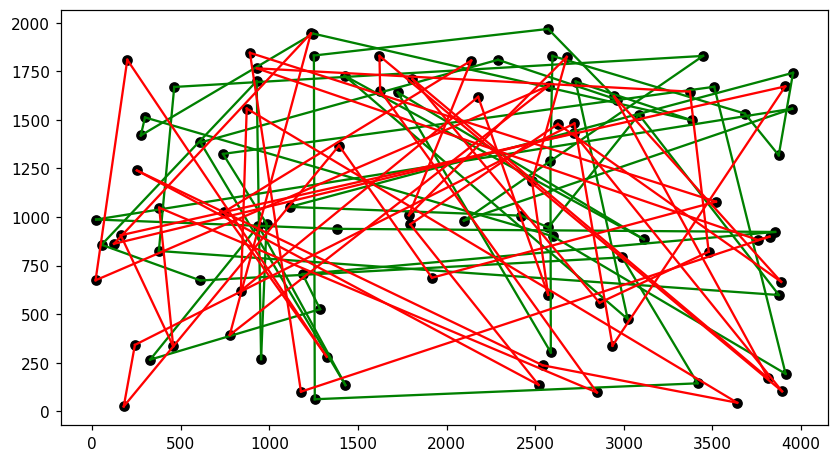

file: kroA100.tsp, solver: solve_random, search: GreedySearch, variant: vertices, score: 41840.0


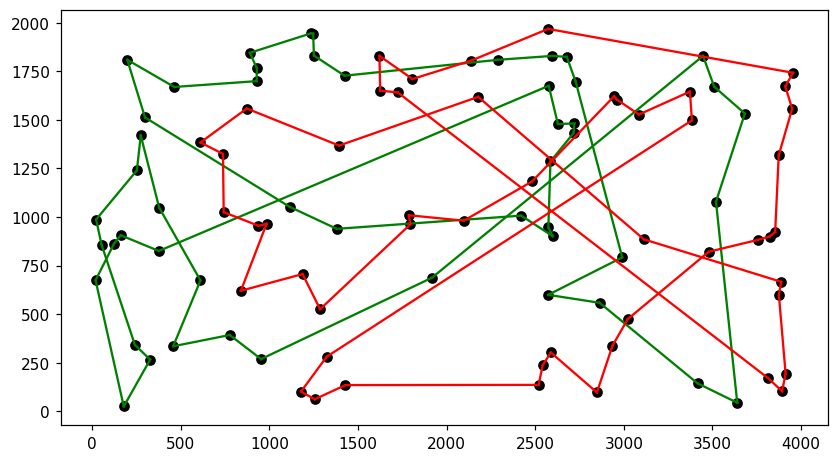

file: kroA100.tsp, solver: solve_random, search: SteepestSearch, variant: vertices, score: 41517.0


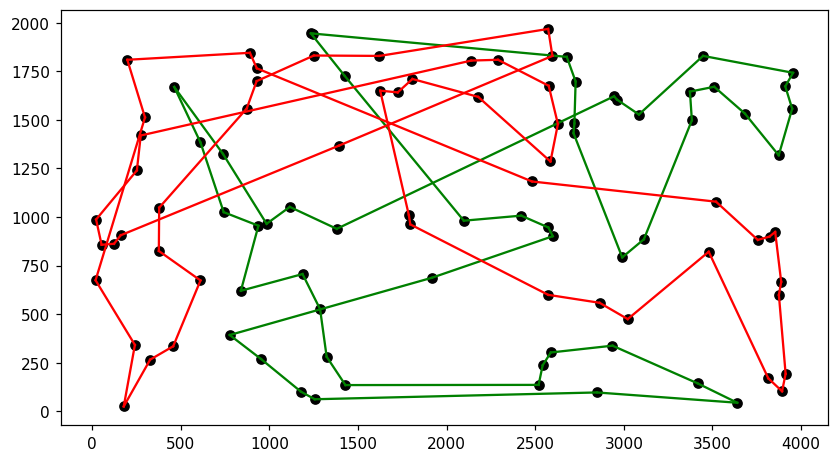

file: kroA100.tsp, solver: solve_random, search: GreedySearch, variant: edges, score: 29428.0


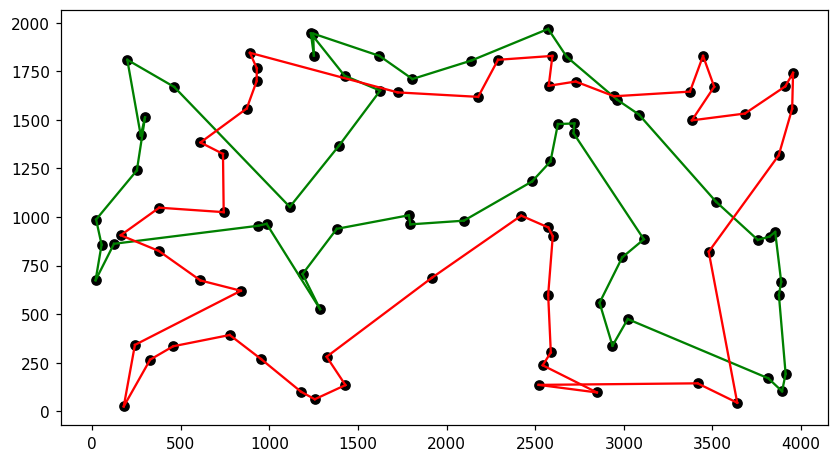

file: kroA100.tsp, solver: solve_random, search: SteepestSearch, variant: edges, score: 27785.0


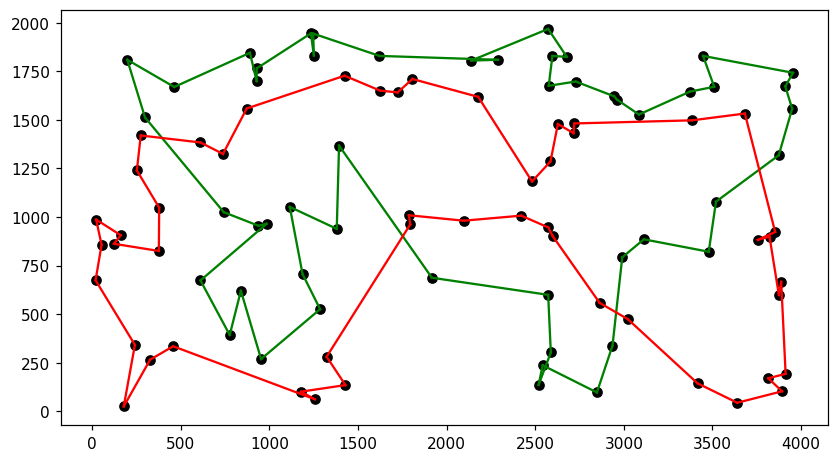

file: kroA100.tsp, solver: solve_random, search: RandomSearch, score: 143781.0


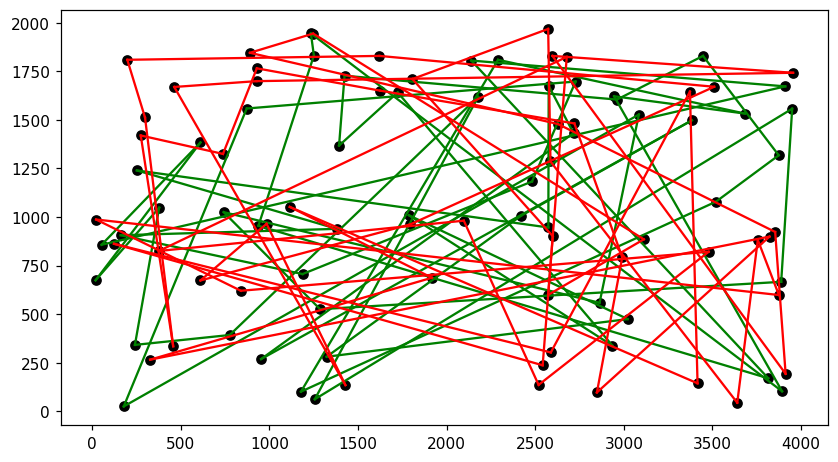

file: kroA100.tsp, solver: solve_regret, search: None, variant: None, score: 22914.0


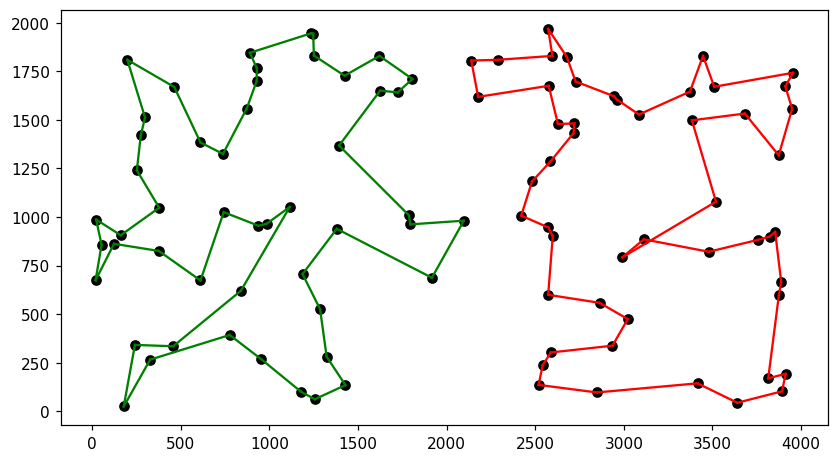

file: kroA100.tsp, solver: solve_regret, search: GreedySearch, variant: vertices, score: 22733.0


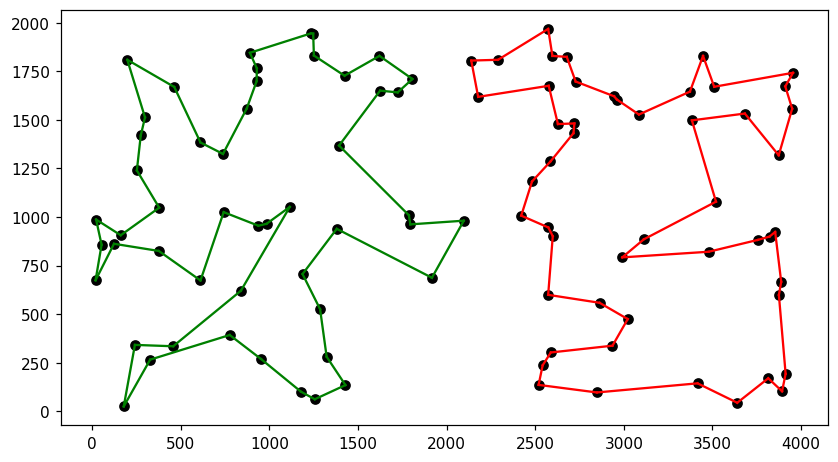

file: kroA100.tsp, solver: solve_regret, search: SteepestSearch, variant: vertices, score: 22733.0


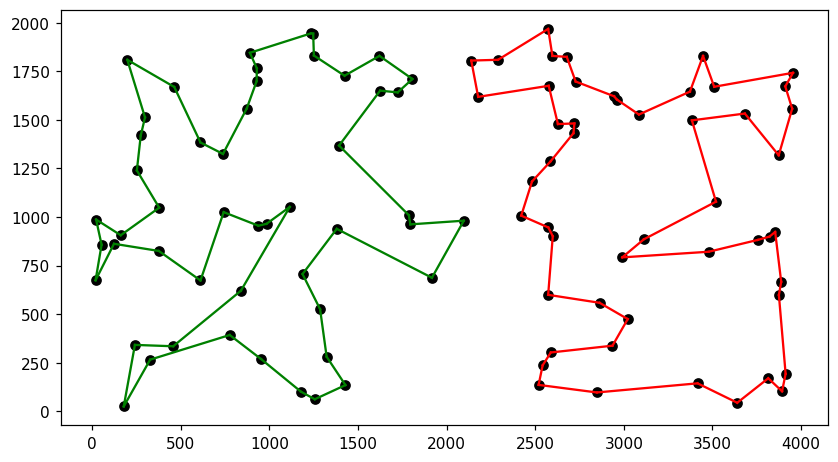

file: kroA100.tsp, solver: solve_regret, search: GreedySearch, variant: edges, score: 22914.0


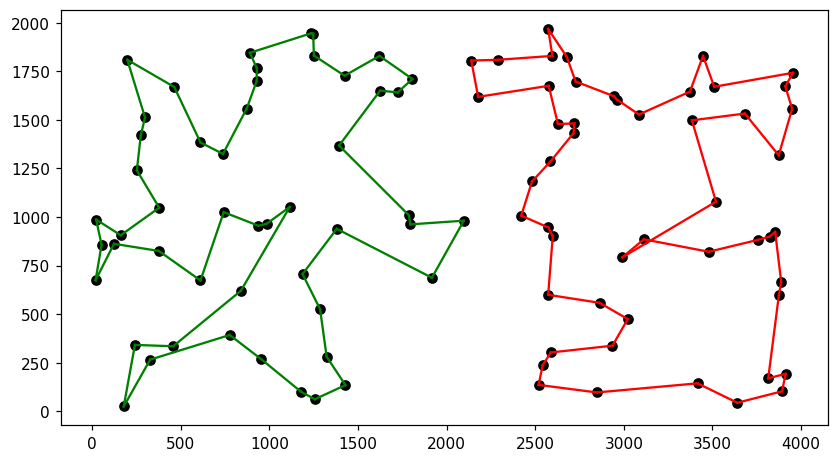

file: kroA100.tsp, solver: solve_regret, search: SteepestSearch, variant: edges, score: 22914.0


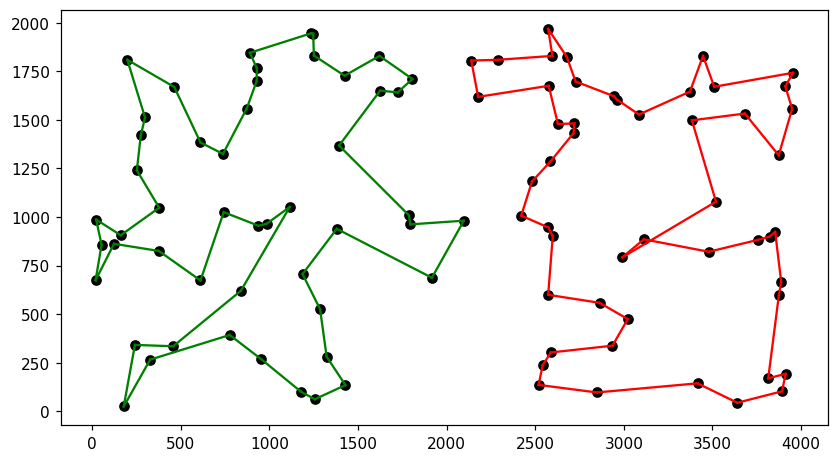

file: kroB100.tsp, solver: solve_random, search: None, variant: None, score: 147956.0


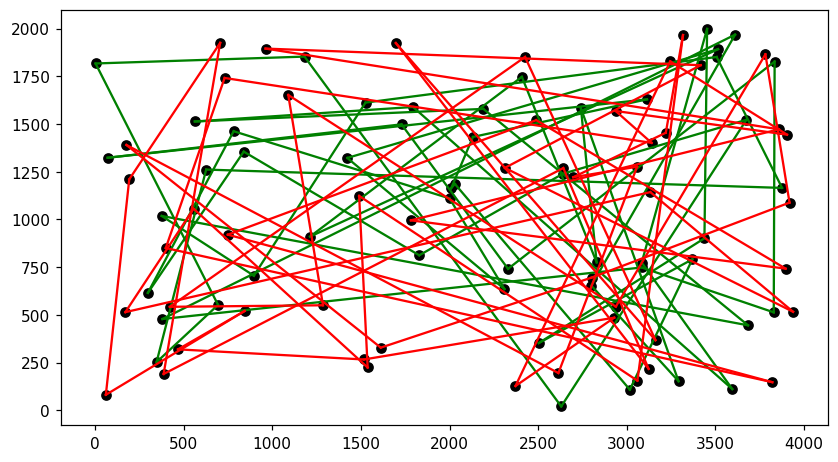

file: kroB100.tsp, solver: solve_random, search: GreedySearch, variant: vertices, score: 41171.0


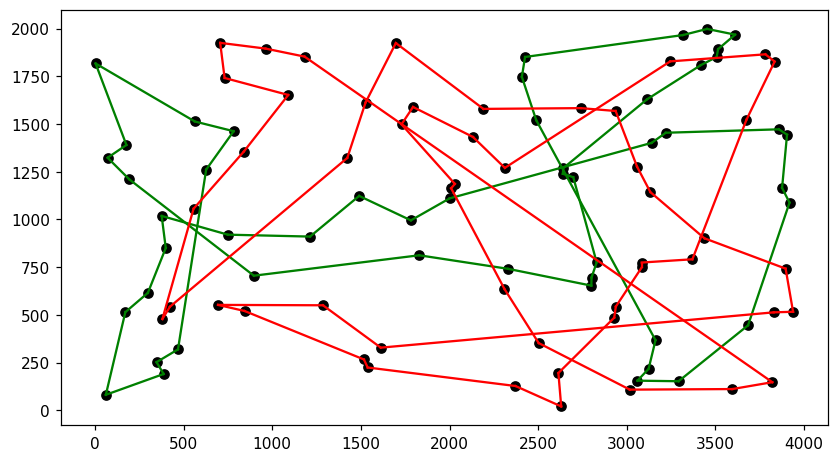

file: kroB100.tsp, solver: solve_random, search: SteepestSearch, variant: vertices, score: 45846.0


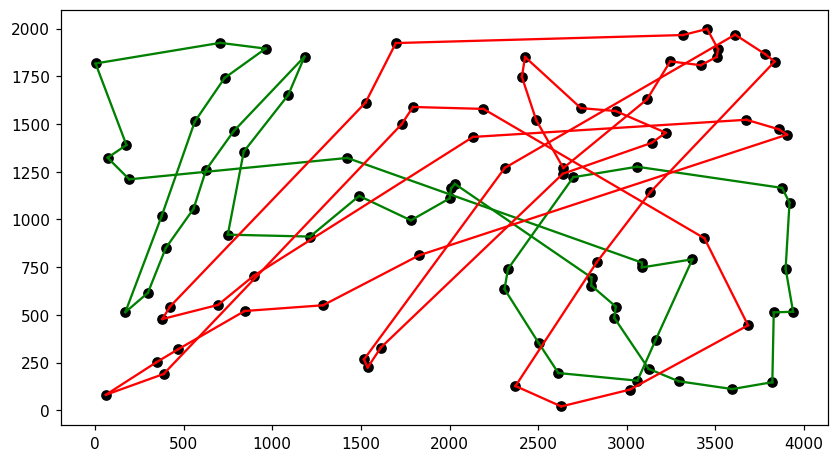

file: kroB100.tsp, solver: solve_random, search: GreedySearch, variant: edges, score: 28094.0


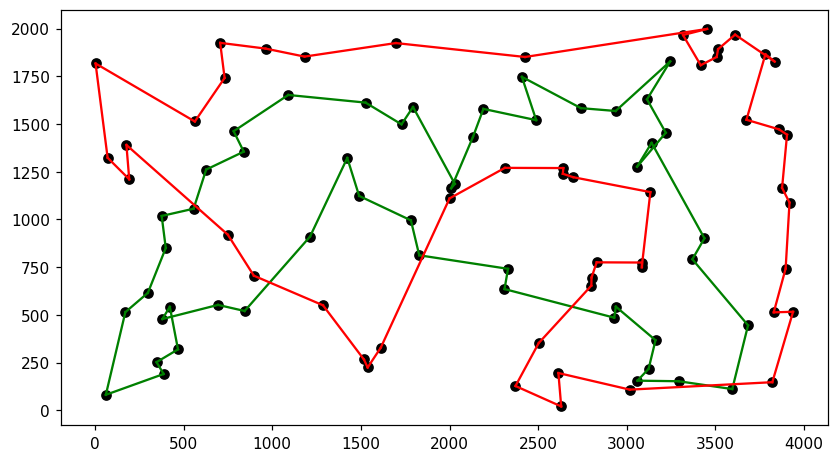

file: kroB100.tsp, solver: solve_random, search: SteepestSearch, variant: edges, score: 29684.0


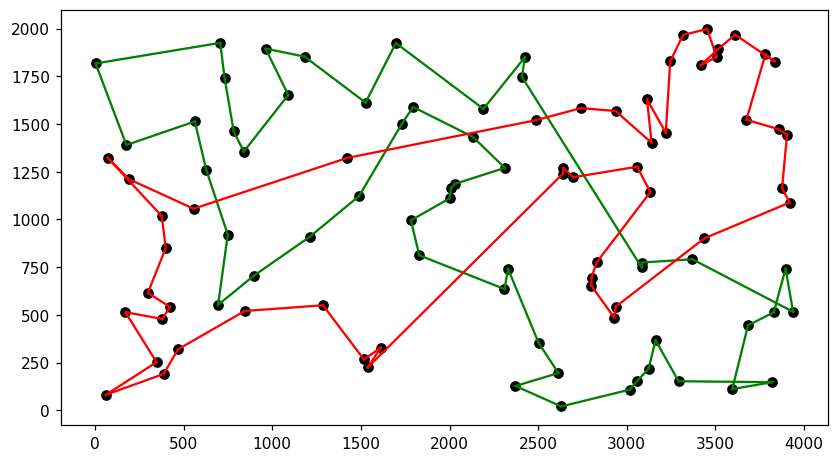

file: kroB100.tsp, solver: solve_random, search: RandomSearch, score: 145160.0


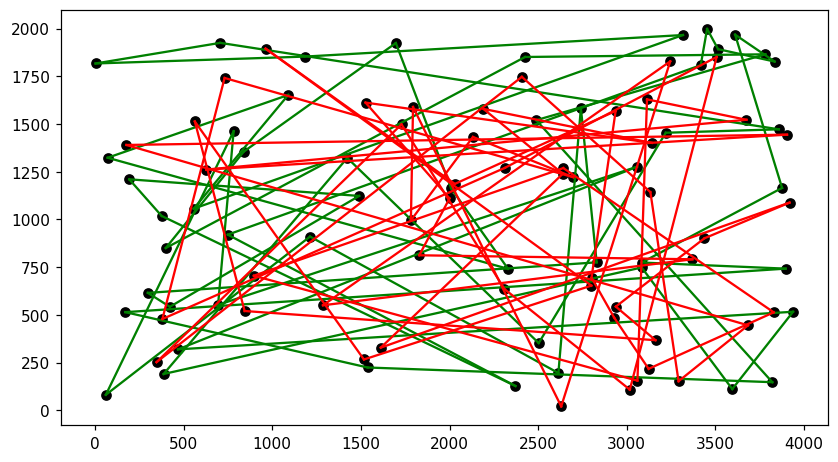

file: kroB100.tsp, solver: solve_regret, search: None, variant: None, score: 24172.0


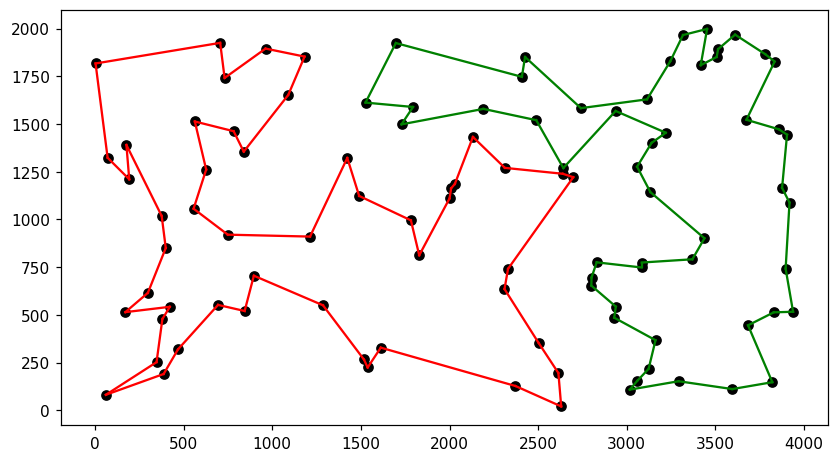

file: kroB100.tsp, solver: solve_regret, search: GreedySearch, variant: vertices, score: 23770.0


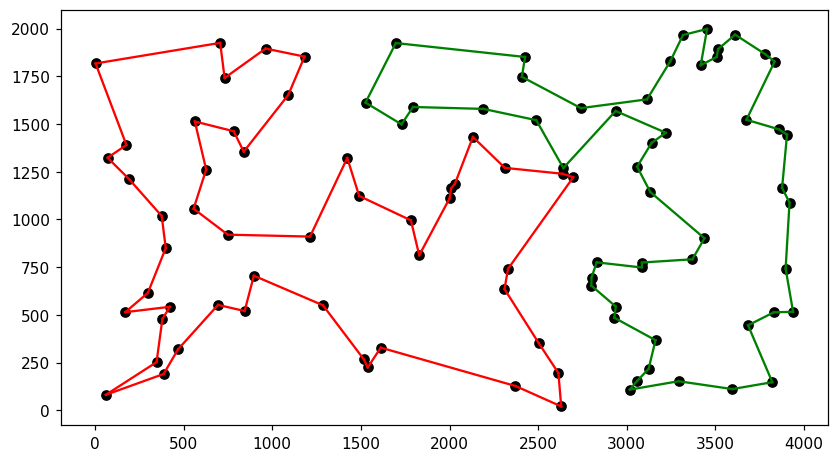

file: kroB100.tsp, solver: solve_regret, search: SteepestSearch, variant: vertices, score: 23770.0


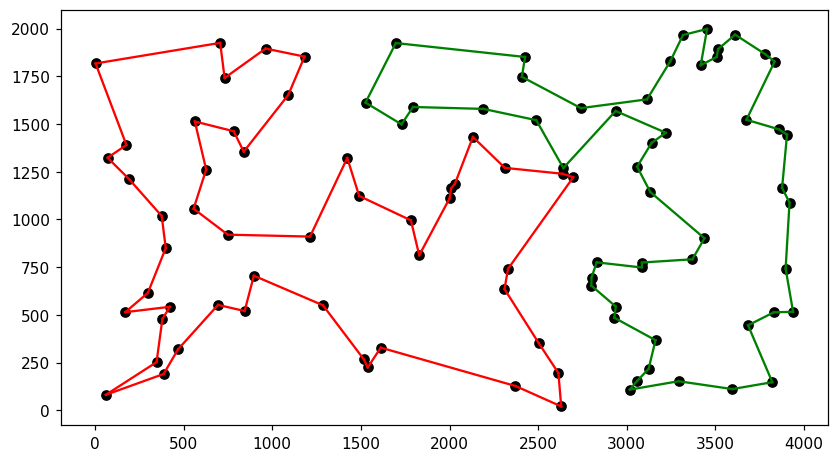

file: kroB100.tsp, solver: solve_regret, search: GreedySearch, variant: edges, score: 24035.0


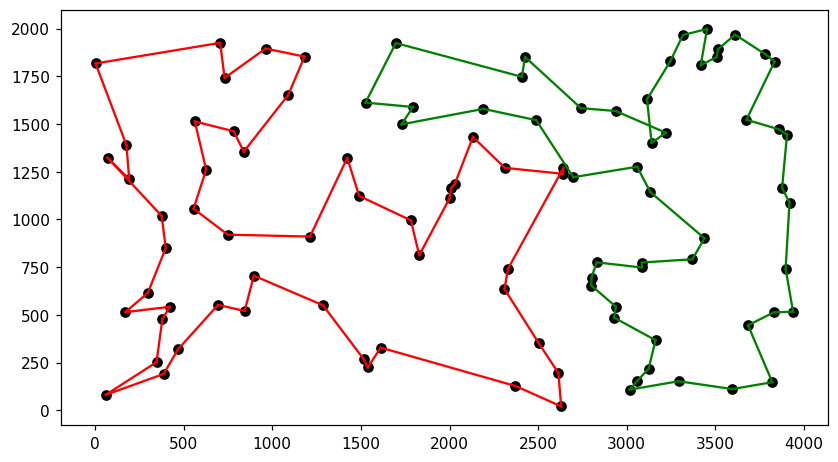

file: kroB100.tsp, solver: solve_regret, search: SteepestSearch, variant: edges, score: 24007.0


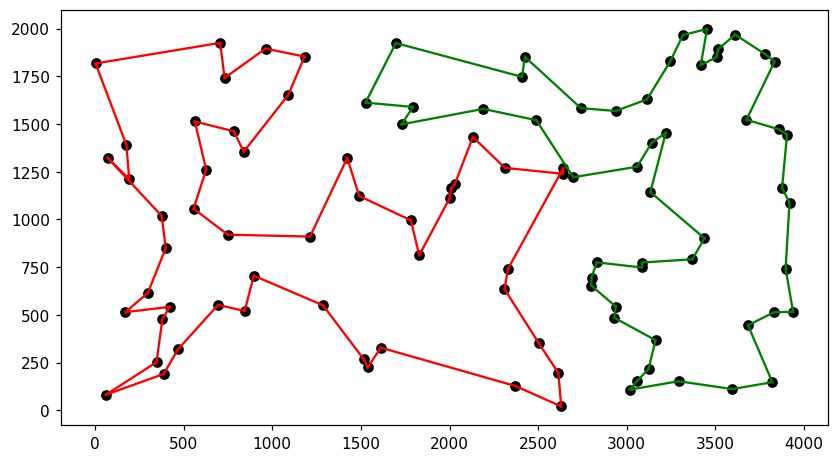

In [12]:
scores, times = show_results()

In [13]:
scores

,file,function,search,variant,min,mean,max
0,kroA100.tsp,solve_random,none,none,154573,171303,191451
1,kroA100.tsp,solve_random,GreedySearch,vertices,32217,40801,48825
2,kroA100.tsp,solve_random,SteepestSearch,vertices,35283,43053,52014
3,kroA100.tsp,solve_random,GreedySearch,edges,26109,28732,31250
4,kroA100.tsp,solve_random,SteepestSearch,edges,26596,28648,32010
5,kroA100.tsp,solve_random,RandomSearch,none,136803,145468,153281
6,kroA100.tsp,solve_regret,none,none,22914,26840,29510
7,kroA100.tsp,solve_regret,GreedySearch,vertices,22733,25406,28450
8,kroA100.tsp,solve_regret,SteepestSearch,vertices,22733,25352,27447
9,kroA100.tsp,solve_regret,GreedySearch,edges,22410,25122,28077


In [14]:
times

,file,function,search,variant,min,mean,max
0,kroA100.tsp,solve_random,GreedySearch,vertices,0.427852,0.748996,1.325175
1,kroA100.tsp,solve_random,SteepestSearch,vertices,1.210537,2.314893,3.174742
2,kroA100.tsp,solve_random,GreedySearch,edges,0.305550,0.587970,0.992946
3,kroA100.tsp,solve_random,SteepestSearch,edges,0.874049,1.530090,1.891923
4,kroA100.tsp,solve_regret,GreedySearch,vertices,0.024653,0.127564,0.416695
5,kroA100.tsp,solve_regret,SteepestSearch,vertices,0.036473,0.228796,0.553297
6,kroA100.tsp,solve_regret,GreedySearch,edges,0.011888,0.081142,0.169383
7,kroA100.tsp,solve_regret,SteepestSearch,edges,0.009126,0.159274,0.352270
8,kroB100.tsp,solve_random,GreedySearch,vertices,0.348991,0.742845,1.209482
9,kroB100.tsp,solve_random,SteepestSearch,vertices,1.504097,2.393119,3.221496
